In [1]:
%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


In [2]:
from scipy import *
from scipy.constants import e, h, hbar
from qutip import *

In [3]:
font = {"size":20}
matplotlib.rc("font", **font)

In [78]:
C_q = 90e-15
Φ = 0 # in Φ_0

def E_C():
    return (e)**2/2/C_q/h/1e9
def E_J():
    return (6+E_C())**2/8/E_C()*cos(pi*Φ)

In [79]:
E_J()/E_C()

104.24114800731283

In [147]:
N_q = 5
gamma = .1

In [99]:
def n():
    return Qobj((diag(arange(-N_q, N_q+1, 1))))
def H_q():
    return 4*E_C()*n()**2+ E_J()/2*(Qobj(diag(ones(2*N_q), 1) + diag(ones(2*N_q), -1)))
def c():
    evals, evecs = H_q().eigenstates()
    return sum([n().matrix_element(evecs[j], evecs[j+1])/n().matrix_element(evecs[0], evecs[1])*evecs[j]*evecs[j+1].dag() for j in range(0, N_q)]) 

In [149]:
evals, evecs = H_q().eigenstates()

In [150]:
(c()*evecs[1]).dag()*evecs[0]

Quantum object: dims = [[1], [1]], shape = [1, 1], type = oper, isherm = True
Qobj data =
[[ 1.]]

In [102]:
evals[2]-evals[1] - evals[1]+evals[0], evals[1]-evals[0], evals[2]-evals[0]

(-0.23497686116099459, 5.9918038157876481, 11.748630770414302)

In [167]:
Ts = linspace(0, 1000, 1000)
f_q = 0.05

args = {}
args["omega"] = evals[1]-evals[0]

opts = Options(rhs_reuse=True)

states = mesolve([H_q(), [n()*f_q, "sin(omega*t)"]], evecs[0]*evecs[0].dag(), Ts, [gamma*c()], [], args=args, progress_bar=True).states
# states = mesolve([H_q(), [(Qobj(diag(ones(2*N_q), 1) + diag(ones(2*N_q), -1))), f_q*sin((evals[1]-evals[0])*Ts)]], evecs[0], Ts, [], [], progress_bar=True).states

# c0s = [abs((state.dag()*evecs[0]).data[0,0])**2 for state in states]
# c1s = [abs((state.dag()*evecs[1]).data[0,0])**2 for state in states]
# c2s = [abs((state.dag()*evecs[2]).data[0,0])**2 for state in states]
# c3s = [abs((state.dag()*evecs[3]).data[0,0])**2 for state in states]

c0s = [abs((state.dag()*(evecs[0]*evecs[0].dag())).tr()) for state in states]
c1s = [abs((state.dag()*(evecs[1]*evecs[1].dag())).tr()) for state in states]
c2s = [abs((state.dag()*(evecs[2]*evecs[2].dag())).tr()) for state in states]
c3s = [abs((state.dag()*(evecs[3]*evecs[3].dag())).tr()) for state in states]


10.0%. Run time:   2.18s. Est. time left: 00:00:00:19
20.0%. Run time:   4.54s. Est. time left: 00:00:00:18
30.0%. Run time:   7.49s. Est. time left: 00:00:00:17
40.0%. Run time:  10.87s. Est. time left: 00:00:00:16
50.0%. Run time:  14.40s. Est. time left: 00:00:00:14
60.0%. Run time:  17.32s. Est. time left: 00:00:00:11
70.0%. Run time:  20.19s. Est. time left: 00:00:00:08
80.0%. Run time:  23.53s. Est. time left: 00:00:00:05
90.0%. Run time:  26.92s. Est. time left: 00:00:00:02
Total run time:  29.52s


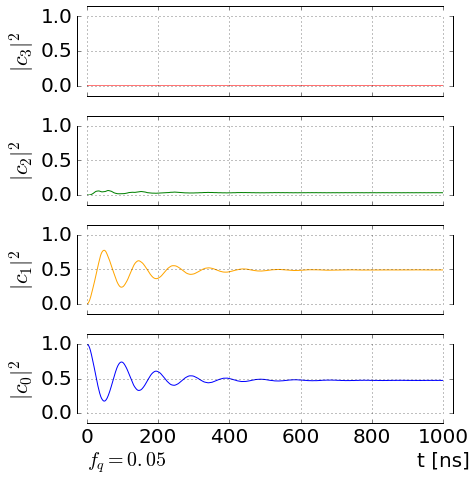

In [168]:
fig, axes = plt.subplots(nrows = 4, ncols=1, figsize=(7,7))

lines = [c0s, c1s, c2s, c3s]
colors = ["blue", "orange", "green", "red"]
for idx, cs, ax in zip(range(0, 4), lines, axes[::-1]):
    ax.plot(Ts, cs, color = colors[idx])
    dict(ax.spines.items())["left"].set_position(('outward', 10))
    dict(ax.spines.items())["bottom"].set_position(('outward', 10))
    dict(ax.spines.items())["top"].set_position(('outward', 10))
    dict(ax.spines.items())["right"].set_position(('outward', 10))
    ax.set_ylim(0, 1)
    ax.grid()
    ax.set_yticks((0,.5,1))
    ax.set_ylabel("$|c_%i|^2$"%idx, fontsize=22)
    if idx > 0:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("t [ns]",position=(1,0))
        ax.annotate("$f_q = %.2f$"%f_q, (0,0), xytext=(0,-0.75), textcoords="axes fraction")
plt.tight_layout()
plt.savefig("tr_vstr_dr.pdf", format="pdf")

In [198]:
ks = linspace(0.9, 1.1)

opts = Options(rhs_reuse=True, nsteps=1e4)
rhs_clear()

def parallel_task(omega):
    args = dict(omega=omega)
    T = 2*pi/omega
    U = propagator([H_q(), [n()*f_q, "sin(omega*t)"]], T, [gamma*c()], options=opts, args=args)
    return propagator_steadystate(U)

states = parallel_map(parallel_task, ks*(evals[1]-evals[0]), progress_bar=True, num_cpus=4)

10.0%. Run time:  40.77s. Est. time left: 00:00:06:06
20.0%. Run time:  59.85s. Est. time left: 00:00:03:59
30.0%. Run time:  80.49s. Est. time left: 00:00:03:07
40.0%. Run time: 101.30s. Est. time left: 00:00:02:31
50.0%. Run time: 135.51s. Est. time left: 00:00:02:15
60.0%. Run time: 154.38s. Est. time left: 00:00:01:42
70.0%. Run time: 172.58s. Est. time left: 00:00:01:13
80.0%. Run time: 192.72s. Est. time left: 00:00:00:48
90.0%. Run time: 225.42s. Est. time left: 00:00:00:25
100.0%. Run time: 238.45s. Est. time left: 00:00:00:00
Total run time: 238.51s


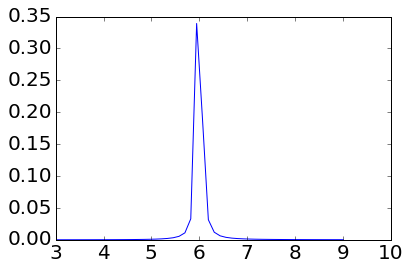

In [192]:
c0s = [abs((state.dag()*(evecs[1]*evecs[1].dag())).tr()) for state in states]
plt.plot(ks*(evals[1]-evals[0]), c0s)